In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image
from itertools import product
from functools import partial, wraps
from sympy import primerange, isprime, log
from tqdm import tqdm

# 1. Chess

In [134]:
INITIAL = np.array([[-4, -2, -4, -5, -6, -3, -2, -4],
                    [-1, -1, -1, -1, -1, -1, -1, -1],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1],
                    [4, 2, 4, 5, 6, 3, 2, 4]])

PIECES = " ♟♞♝♜♛♚"


class Chess:
    def __init__(self, broad: np.ndarray = INITIAL):
        self.state = broad
        startcolor = (209/255, 139/255, 71/255)
        endcolor = (255/255, 206/255, 158/255)
        self.cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'my_cmap', [startcolor, endcolor], 40)
        self.size = 8

    def draw(self):
        self.draw_broad()
        self.draw_pieces()

    def draw_pieces(self):
        for x, y in product(range(self.size), repeat=2):
            code = self.state[x, y]
            if code == 0:
                continue
            piece = PIECES[abs(code)]
            color = "white" if code//abs(code) > 0 else "black"
            plt.scatter(y, self.size - 1 - x,
                        marker=f"${piece}$", color=color, s=250)

    def draw_broad(self):
        pannel = np.zeros([self.size, self.size], float)
        for nx, ny in product(range(self.size), repeat=2):
            if (nx+ny) % 2 == 1:
                pannel[nx, ny] = 1
        plt.imshow(pannel, cmap=self.cmap)
        plt.xticks(np.arange(0, 8), ('a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'))
        plt.xlim([-0.5, 7.5])
        plt.yticks(np.arange(0, 8), ('1', '2', '3', '4', '5', '6', '7', '8'))
        plt.ylim([-0.5, 7.5])
        plt.tick_params(bottom=False, left=False,
                        labeltop=True, labelright=True)


## a)

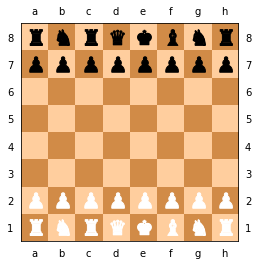

In [135]:
Chess().draw()

## b)

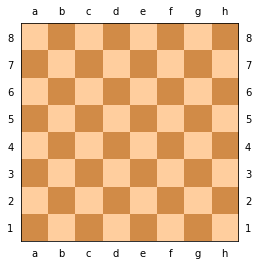

In [138]:
Chess(broad=np.zeros((8,8))).draw()

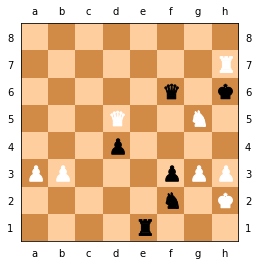

In [136]:
DEEPBLUE = np.array([[0, 0, 0,  0,  0,  0, 0,  0],
                     [0, 0, 0,  0,  0,  0, 0,  4],
                     [0, 0, 0,  0,  0, -5, 0, -6],
                     [0, 0, 0,  5,  0,  0, 2,  0],
                     [0, 0, 0, -1,  0,  0, 0,  0],
                     [1, 1, 0,  0,  0, -1, 1,  1],
                     [0, 0, 0,  0,  0, -2, 0,  6],
                     [0, 0, 0,  0, -4,  0, 0,  0]])

Chess(broad=DEEPBLUE).draw()

# 2. Supermarket

# 3. Artificial landscape

In [2]:
from matplotlib.cm import terrain
from matplotlib.colors import ListedColormap as LC
terrain_above_sea = LC(terrain(np.linspace(.15, 1, 256)))

def generate_landscape():
    """ Generate the altitudes of a random but smooth landscape.
        You do not need to understand how they are generated.
    
    Returns
    -------
    z: ndarray of float
        A 101*101 array of altitude.
        The sea level has an altitude of 0.
        
        Using the Cartesian coordinates (x, y),
        the element z[i, j] is the altitude at point (x=j/100, y=i/100).
        
        Note that x is proportional to j, whereas y is proportional to i.
        For example,
            * z[12, 34] is the altitude at point (x=.34, y=.12)
            * z[56, :] are the altitudes along y=.56
            * z[:, 78] are the altitudes along x=.78      
    """
    n, N = 20, 101
    x = y = np.arange(0, n, 1)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros((n, n))
    zz[:, 0], zz[0, :] = np.random.randn(2, n)
    for i in range(1, n):
        for j in range(1, n):
            zz[i, j] = ( zz[i-1, j]+zz[i, j-1] )/2 + np.random.randn()

    from scipy import interpolate
    from warnings import filterwarnings
    filterwarnings('ignore')
    x, y = np.linspace(0, n-1, N), np.linspace(0, n-1, N)
    return interpolate.bisplev(
        x, y, interpolate.bisplrep(
            xx.flatten(), yy.flatten(), zz.flatten(), s=1))

In [3]:
np.random.seed(114514)
landscape = np.array(generate_landscape())

## a)

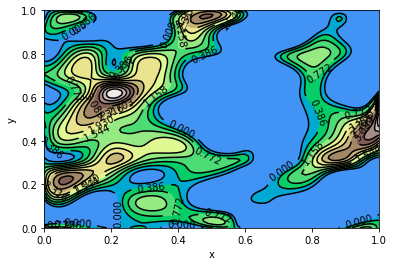

In [224]:
max_z=np.max(landscape)
min_z=np.min(landscape)
above_levels=np.linspace(0,max_z,13)

CSf=plt.contourf(landscape,above_levels,cmap=terrain_above_sea)
plt.contourf(landscape,[min_z,0],colors="#4293f6")
CS=plt.contour(landscape,above_levels,colors="black")
plt.clabel(CS,above_levels)
plt.xticks(np.linspace(0,100,6), np.round(np.linspace(0,1,6),2))
plt.yticks(np.linspace(0,100,6), np.round(np.linspace(0,1,6),2))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## b)

In [11]:
def draw_cross_section(landscape, ny):
    plt.cla()
    zs = landscape[:, ny]
    z_max = np.max(landscape)
    z_min = np.min(landscape)
    plt.imshow([[z_max, z_max], [0, 0]], cmap=terrain_above_sea, extent=[
               0, 100, 0, np.max(zs)], interpolation="bicubic", aspect="auto")
    xs = np.linspace(0, 100, len(zs))
    plt.plot(xs, zs, color="black")
    plt.fill_between(xs, zs, z_max, facecolor='white',
                     interpolate=True, alpha=1)
    plt.fill_between(xs, np.zeros_like(xs), z_min,
                     facecolor="#4293f6", interpolate=True, alpha=1)
    plt.plot(xs, np.zeros_like(xs), color="black", linestyle='dashed')
    plt.text(2, z_max, f"y={ny/100:.2f}")
    plt.xlim([0, 100])
    plt.xticks(np.linspace(0, 100, 6), np.round(np.linspace(0, 1, 6), 2))
    plt.xlabel("x")
    plt.ylabel("z")
    plt.ylim([z_min, z_max+1])


fig = plt.figure()
anim = FuncAnimation(fig, partial(draw_cross_section,
                                  landscape), frames=np.arange(0, 101))

gif_name = "./out/q3.gif"
anim.save(gif_name)
plt.close()

Image(url=gif_name)

MovieWriter ffmpeg unavailable; using Pillow instead.


# 4. Goldbach's conjecture

## a)

In [46]:
def return_in_list(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return list(func(*args, **kwargs))
    return wrapper

@return_in_list
def goldbach(n):
    primes = primerange(n//2+1)
    for p in primes:
        if isprime(n-p):
            yield p


In [4]:
goldbach(100)

[3, 11, 17, 29, 41, 47]

## b)

In [16]:
class EulerSieve:
    def __init__(self, N):
        self.N = N
        self.is_primes = [False, False, *[True for i in range(2, N+1)]]
        self.primes = []
        self.idx4phalf = 0
        for n in tqdm(range(2, N+1), desc="caching primes..."):
            if self.is_primes[n]:
                self.primes.append(n)
                if n <= N//2:
                    self.idx4phalf += 1
            for p in self.primes:
                if (q := n*p) > N:
                    break
                self.is_primes[q] = False
                if n % p == 0:
                    break

    def isprime(self, num):
        return self.is_primes[num]


assigning color...: 100%|██████████| 49999/49999 [00:00<00:00, 895190.92it/s]


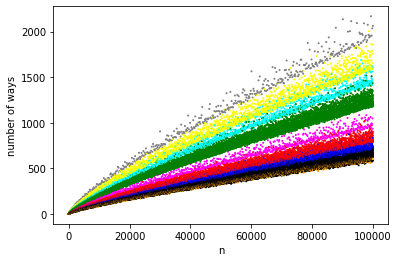

In [20]:
CMAP = {
    3: "green",
    5: "red",
    7: "blue",
    15: "yellow",
    21: "cyan",
    35: "magenta",
    105: "grey"
}


def assign_color(n, euler_sieve):
    for div, c in reversed(CMAP.items()):
        if n % div == 0:
            return c
    if euler_sieve.isprime(n//2):
        return "orange"
    return "black"


def draw_num_goldbach(N):
    euler_sieve = EulerSieve(N)

    nws = np.zeros(N+1)

    totoal = euler_sieve.idx4q2+1
    halfps = euler_sieve.primes[:totoal]

    #p <= N//2
    for i, p in tqdm(enumerate(halfps), total=totoal, desc="calculating ngoldbach..."):
        # q >= p
        for q in euler_sieve.primes[i:]:
            if (s := p+q) > N:
                break
            nws[s] += 1

    ns = range(4, N+1, 2)
    cs = [assign_color(n, euler_sieve)
          for n in tqdm(ns, desc="assigning color...")]

    plt.scatter(ns, nws[4:N+1:2], c=cs, s=1)

    plt.xlabel("n")
    plt.ylabel("number of ways")


draw_num_goldbach(10**5)
plt.savefig("out/q4-b.jpg")
plt.show()


# 5. Image processing

# 6. Minkowski's question mark function

# 7. Bifurcation diagram